This program trains a Linear Regression model to predict the next day's stock closing price based on the current day's opening price and the previous day's closing price, then evaluates the model's performance. As an active gym-goer, I often feel energized and mentally fortified after a workout, which might slightly influence my trading behavior the following day. This led me to hypothesize that gym interest the night before could potentially impact trading volume and subsequently drive stock prices. This project was my first attempt at utilizing various Python libraries and applying the skills I acquired in my statistical modeling course to real-world data analysis.

Reference: https://www.youtube.com/watch?v=PoRwh4PR1Qg

In [1]:
''' import libraries '''

import pandas as pd
import numpy as np
from sklearn import metrics
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler


In [2]:
''' read stock csv downloaded from marketwatch '''

df = pd.read_csv("us_spy_ytd_daily.csv")
#print(df.head())

gym_data = [None, 76, 82, 87, 74, 79, 83, 88, 86, 78, 79, 87, 88, 85, 78, 84, 87, 86, 88, 
            78, 82, 85, 83, 84, 81, 82, 88, 89, 87, 76, 80, 80, 87, 83, 75, 77, 84, 83, 80,
            79, 83, 84, 83, 88, 76, 81, 85, 87, 73, 78, 85, 86, 86, 79, 80, 90, 84, 80, 83, 
            83, 87, 88] #first value of 74 removed for lagged effect


# creating a column of gym data, any blank rows are set to NaN
df['Gym'] = np.nan

df.loc[:len(gym_data) - 1, 'Gym'] = gym_data

print(df.head(5))  

      Date    Open    High     Low   Close      Volume   Gym
0   9/6/24  549.94  551.60  539.44  540.36  68,493,805  None
1   9/5/24  550.89  553.80  547.10  549.61  44,264,262    76
2   9/4/24  550.20  554.43  549.46  550.95  47,224,941    82
3   9/3/24  560.47  560.81  549.51  552.08  60,523,000    87
4  8/30/24  560.77  564.20  557.14  563.68  62,700,113    74


/var/folders/0l/kzr_8ly13rx31smvwrn_yfqh0000gn/T/ipykernel_12937/1984224204.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[None, 76, 82, 87, 74, 79, 83, 88, 86, 78, 79, 87, 88, 85, 78, 84, 87, 86, 88, 78, 82, 85, 83, 84, 81, 82, 88, 89, 87, 76, 80, 80, 87, 83, 75, 77, 84, 83, 80, 79, 83, 84, 83, 88, 76, 81, 85, 87, 73, 78, 85, 86, 86, 79, 80, 90, 84, 80, 83, 83, 87, 88]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:len(gym_data) - 1, 'Gym'] = gym_data


In [3]:
''' shift data and create a new column that shows the close price from the previous day, this is called a lagged feature '''

series_shifted = df ['Close'].shift()
df['prev_close'] = series_shifted
df.head()

,Date,Open,High,Low,Close,Volume,Gym,prev_close
0,9/6/24,549.94,551.60,539.44,540.36,"68,493,805",None,NaN
1,9/5/24,550.89,553.80,547.10,549.61,"44,264,262",76,540.36
2,9/4/24,550.20,554.43,549.46,550.95,"47,224,941",82,549.61
3,9/3/24,560.47,560.81,549.51,552.08,"60,523,000",87,550.95
4,8/30/24,560.77,564.20,557.14,563.68,"62,700,113",74,552.08


In [4]:
''' check how many rows there are, and if there are any null entries '''

print (df.shape)
df.isnull().sum()


(172, 8)


Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Gym           111
prev_close      1
dtype: int64

In [5]:
''' drop null entry '''

df.dropna(inplace = True)
df


,Date,Open,High,Low,Close,Volume,Gym,prev_close
1,9/5/24,550.89,553.80,547.10,549.61,"44,264,262",76,540.36
2,9/4/24,550.20,554.43,549.46,550.95,"47,224,941",82,549.61
3,9/3/24,560.47,560.81,549.51,552.08,"60,523,000",87,550.95
4,8/30/24,560.77,564.20,557.14,563.68,"62,700,113",74,552.08
5,8/29/24,560.31,563.68,557.18,558.35,"38,715,180",79,563.68
...,...,...,...,...,...,...,...,...
57,6/14/24,540.88,542.81,539.85,542.78,"40,089,898",80,547.10
58,6/13/24,543.15,543.33,539.59,542.45,"44,760,953",83,542.78
59,6/12/24,541.63,544.12,540.30,541.36,"63,251,312",83,542.45
60,6/11/24,534.07,537.01,532.05,536.95,"36,383,406",87,541.36


<Axes: >

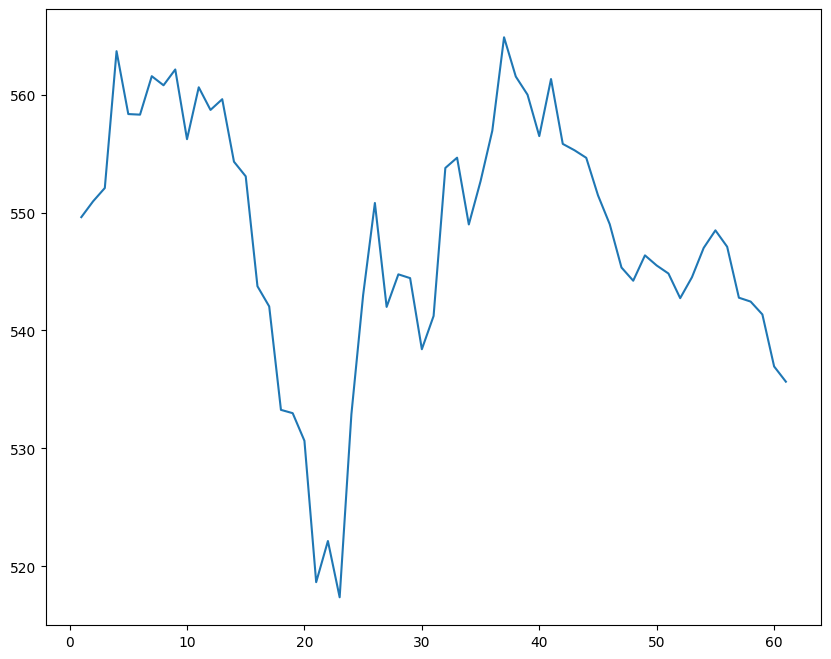

In [6]:
''' close prices '''
df['Close'].plot(figsize=(10,8))

In [7]:
''' x and y axes'''
x = df[['prev_close', 'Gym']]
y = df['Close']

In [8]:
''' split the dataset into two parts: one for training the model (x_train and y_train) and one for testing it (x_test and y_test). The train_test_split function ensures that the division is random but consistent each time it's run, thanks to the random_state parameter '''

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,random_state=0)

In [9]:
''' check how much data is avaiable for training and testing '''
print(x_train.shape, x_test.shape)

(45, 2) (16, 2)


In [10]:
''' create and train Linear Regression model '''

from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, accuracy_score
regressor = LinearRegression()
regressor.fit(x_train, y_train)

LinearRegression()

In [11]:
''' print regressors '''

print(regressor.coef_)
print(regressor.intercept_)

[ 0.84264463 -0.20844897]
103.69310898605613


In [12]:
''' round predicted value '''

predicted_unrounded = regressor.predict(x_test)
predicted = [round(value, 2) for value in predicted_unrounded]
print(x_test)

    prev_close Gym
27      550.81  89
36      552.66  84
61      536.95  88
29      544.76  76
12      560.62  88
3       550.95  87
35      548.99  77
60      541.36  87
41      556.48  84
23      522.15  84
5       563.68  79
11      556.22  87
31      538.41  80
42      561.32  83
34      554.65  75
44      555.28  76


In [13]:
''' count original predicted values '''
predicted_unrounded.shape


(16,)

In [14]:
''' create and print a DataFrame with actual and predicted values '''

_df = pd.DataFrame({"Actual": y_test, "Predicted": predicted})
print(_df.head(5))

    Actual  Predicted
27  542.00     549.28
36  556.94     551.88
61  535.66     537.81
29  544.44     546.89
12  558.70     557.75


In [15]:
''' calculate the R² score (0 to 1.0) to evaluate the model's performance on the test data. A good R² score is closer to 1, meaning the model's predictions are close to the actual values and explain most of the variation (differences) in the target variable '''

regressor.score(x_test, y_test)

0.8314939941855617

In [16]:
''' calculate rounded metrics '''
import math

mae = metrics.mean_absolute_error(y_test, predicted)
mse = metrics.mean_squared_error(y_test, predicted)
rmse = math.sqrt(mse)

print("Mean Absolute Error:", round(mae, 2))
# Measures average distance between predictions and actual.
# Lower MAE is better, with 0 being ideal.
# For example, if MAE is 5, predictions are off by about 5 units on average.

print("Mean Squared Error:", round(mse, 2))
# Measures the average of the squared differences between predictions and actual.
# Lower MSE is better, with 0 being ideal.
# For example, an MSE of 25 means the squared differences average to 25.

print("Root Mean Squared Error:", round(rmse, 2))
# Square root of MSE, which puts the error back in the same units as the target variable.
# Lower RMSE is better, with 0 being ideal.
# For example, if RMSE is 5, predictions are off by about 5 units on average.


Mean Absolute Error: 4.01
Mean Squared Error: 21.94
Root Mean Squared Error: 4.68


In [17]:
predicted = regressor.predict(x)
print(predicted)

[543.18244056 549.72620958 549.81310854 553.47513359 562.20756647
 556.8824747  555.79809761 558.96201705 559.98077245 560.90146729
 554.25384575 557.75303316 556.76050238 558.98645178 553.26974141
 551.59951516 543.95451616 542.0966959  536.79119218 535.7214558
 533.12432045 523.43790925 526.17029005 522.77622207 535.64561778
 542.91406119 549.27824035 542.27143908 546.89007694 545.78663478
 540.70548765 541.62260272 553.03158873 555.43228132 550.24601476
 551.87937777 555.69434577 562.99343816 560.39588051 558.26441189
 555.09828026 559.38512925 553.70833893 555.75469847 554.17316105
 550.65975524 548.17837795 548.00415774 546.0181509  546.37069406
 545.43757071 544.86457236 544.56258787 545.8456199  545.85931533
 548.36554965 548.0280695  543.76249778 543.48442505 541.73214652
 537.80763472]


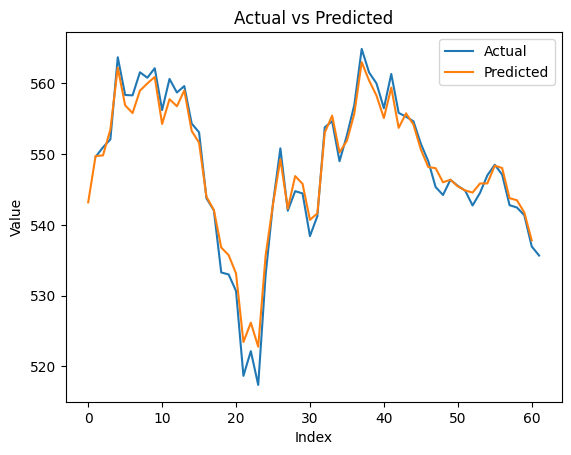

In [18]:
''' Plot the graph '''

plt.plot(y, label="Actual")
plt.plot(predicted, label="Predicted")
plt.xlabel("Index") #date
plt.ylabel("Value")
plt.title("Actual vs Predicted")
plt.legend()
plt.show()

In [19]:
# Add a constant (intercept) to the predictors for the OLS regression model.
# This ensures the regression line includes a y-intercept.
# Convert columns to numeric, forcing errors to NaN (which will need to be handled later)
x = x.apply(pd.to_numeric, errors='coerce') #match values
y = pd.to_numeric(y, errors='coerce') #match values

x = sm.add_constant(x)

# Fit the OLS (Ordinary Least Squares) model
# OLS is used to find the best-fitting linear relationship by minimizing the sum of squared residuals.
model = sm.OLS(y, x).fit()

print(model.pvalues)
# P-values indicate the significance of each predictor variable.
# Low p-values (typically < 0.05) suggest the variable is a significant predictor of the target.

const         3.919279e-02
prev_close    2.950268e-20
Gym           3.051048e-01
dtype: float64


- Evaluate p-values: The p-values in the model are extremely low, which indicates that the predictor variables (x-variables) are statistically significant in explaining the target variable (y-variable). Generally, a p-value < 0.05 suggests strong evidence against the null hypothesis, meaning the variables have a meaningful impact on the predictions.

- Evaluate Model Accuracy: The model currently shows 99.6% accuracy, which is very high but could indicate overfitting. Overfitting happens when the model learns patterns from the training data too well, reducing its effectiveness when applied to new, unseen data.

- We need to check for multicollinearity. If predictor variables (x-variables) are highly correlated with each other, it can lead to unstable and unreliable coefficient estimates. We use the Variance Inflation Factor (VIF) to detect this issue. A VIF value > 5 typically indicates high multicollinearity, meaning some variables may need to be removed or adjusted to improve the model's reliability.


In [20]:

''' standardize the data to ensure all features are on the same scale, as VIF can be sensitive to scale differences '''
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

''' create a DataFrame for the scaled data '''
x_scaled_df = pd.DataFrame(x_scaled, columns=x.columns)

''' find VIF for each feature (x-variable/predictor/independent variable) '''
vif_data = pd.DataFrame()
vif_data['Feature'] = x.columns
vif_data['VIF'] = [variance_inflation_factor(x_scaled_df.values, i) for i in range(x_scaled_df.shape[1])]

print(vif_data)



      Feature       VIF
0       const       NaN
1  prev_close  1.001532
2         Gym  1.001532


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1785: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Here’s a revised version reflecting the focus on whether gym interest the night before would affect stock prices the next day, and incorporating the R² decrease:

---

In this project, I investigated whether gym interest the night before would affect stock prices the next day.

### Project Overview:

1. **Objective:**
   - I aimed to determine if gym interest measured the night before has a significant impact on the stock prices of companies the following day. Specifically, I wanted to see if increased gym interest, as reflected in Google Trends data, could predict the next day’s stock performance.

2. **Methodology:**
   - **Data Collection:** I gathered historical stock price data and Google Trends data on gym interest.
   - **Creating Lagged Effect:** To capture the potential influence of gym interest from one day on stock prices the next day, I created a lagged feature. This involved adding a column to my dataset showing gym interest from the previous day, while keeping the current day’s gym interest data for reference.
   - **Linear Regression Analysis:** I used linear regression to model the relationship between stock prices (the dependent variable) and both the current day’s gym interest and the previous day’s gym interest (independent variables), along with other stock-related predictors like the previous close price.
   - **Evaluation:** The model’s R² value decreased by 16.6% compared to the baseline, resulting in an R² of approximately 0.831. This decrease indicates a weaker correlation between the predictors and stock prices, supporting the null hypothesis that gym interest the night before does not significantly impact next-day stock performance.

3. **Results:**
   - The decrease in the R² value suggests that the correlation between the predictors and stock prices is weaker than initially expected. This supports the null hypothesis that gym interest from the previous day does not have a significant effect on the stock prices of these companies.

### Summary:

I used linear regression to explore whether gym interest from the night before affects stock prices the following day. By incorporating both current and lagged gym interest data, I found that the R² value decreased by 16.6%, indicating a weaker correlation and supporting the null hypothesis that past gym interest does not significantly impact stock performance.

---